In [4]:
# inspired by https://gist.github.com/yanofsky/5436496


'''
@author Manuel Kohler
'''

%matplotlib inline 

import twitter

import tweepy
import csv
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import datetime
from datetime import timezone
from pytz import timezone
from datetime import timedelta
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib
matplotlib.style.use('ggplot')
import json
import os

screen_name = 'realDonaldTrump'
#screen_name = 'rogerfederer'

_count = 200

base_dir = '/Users/kohleman/PycharmProjects/twitter/twitter_api/twitter_api/data/'
raw_data_file = os.path.join(base_dir, 'raw_tweets_{0}.json'.format(screen_name))

# Login to API


auth = OAuthHandler(ckey, csecrect)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)


class listener(StreamListener):

    def on_data(self, raw_data):
        print(raw_data)
        return True

    def on_error(self, status_code):
        print(status_code)

        
def extract_json(raw_tweets):
    return [[tweet._json] for tweet in raw_tweets]

In [5]:
# Access current stream
twitterStream = Stream (auth, listener())
#twitterStream.filter(track=["#trump"])

In [6]:
def get_all_tweets(screen_name):
    # taken some code from https://github.com/adilmoujahid/Twitter_Analytics/blob/master/analyze_tweets.py
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #initialize a list to hold all the tweepy Tweets
    alltweets = []

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count = _count)

    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print("getting tweets before {0}".format(oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name, count = _count, max_id = oldest)

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        print("...{0} tweets downloaded so far".format(len(alltweets)))

    #transform the tweepy tweets into a 2D array that will populate the csv	
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]
    
    #write the csv
    with open(os.path.join(base_dir, '{0}_all_tweets.csv'.format(screen_name)), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)

    return alltweets
    


In [8]:
alltweets = get_all_tweets(screen_name)

getting tweets before 821719763214880768
...400 tweets downloaded so far
getting tweets before 808642018612310015
...600 tweets downloaded so far
getting tweets before 795057936565313535
...800 tweets downloaded so far
getting tweets before 789224624320028671
...1000 tweets downloaded so far
getting tweets before 785913754194104319
...1200 tweets downloaded so far
getting tweets before 781785509639118847
...1400 tweets downloaded so far
getting tweets before 774484342030602239
...1600 tweets downloaded so far
getting tweets before 766627569110249471
...1800 tweets downloaded so far
getting tweets before 759191265988653055
...2000 tweets downloaded so far
getting tweets before 754291925616852991
...2200 tweets downloaded so far
getting tweets before 746272130992644095
...2400 tweets downloaded so far
getting tweets before 738598954468659199
...2600 tweets downloaded so far
getting tweets before 732726105837277183
...2800 tweets downloaded so far
getting tweets before 725722027173249023


In [9]:
# Historic tweets
#http://trumptwitterarchive.com/data/realdonaldtrump/2009.json
#http://trumptwitterarchive.com/data/realdonaldtrump/2010.json
#http://trumptwitterarchive.com/data/realdonaldtrump/2011.json
#http://trumptwitterarchive.com/data/realdonaldtrump/2012.json
#http://trumptwitterarchive.com/data/realdonaldtrump/2013.json
#http://trumptwitterarchive.com/data/realdonaldtrump/2014.json
#http://trumptwitterarchive.com/data/realdonaldtrump/2015.json
#http://trumptwitterarchive.com/data/realdonaldtrump/2016.json
#http://trumptwitterarchive.com/data/realdonaldtrump/2017.json

In [11]:


# Accessing https://dev.twitter.com/rest/reference/get/statuses/user_timeline


# include_rts = include retweets
#new_tweets = api.user_timeline(screen_name = screen_name, count=count, include_rts=True)
# max_id_tweets = api.user_timeline(screen_name = screen_name,count=count, include_rts=True, max_id=818643528905621504)


outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8"), tweet._json] for tweet in alltweets]

json_tweets = extract_json(alltweets)
# older_tweets = extract_json(max_id_tweets)

with open (raw_data_file, 'w') as jsonfile:
    json.dump(json_tweets, jsonfile, ensure_ascii=False, indent=4, separators=(',', ': '))
#     json.dump(older_tweets, jsonfile, ensure_ascii=False, indent=4, separators=(',', ': '))
    




Got 3243 tweets


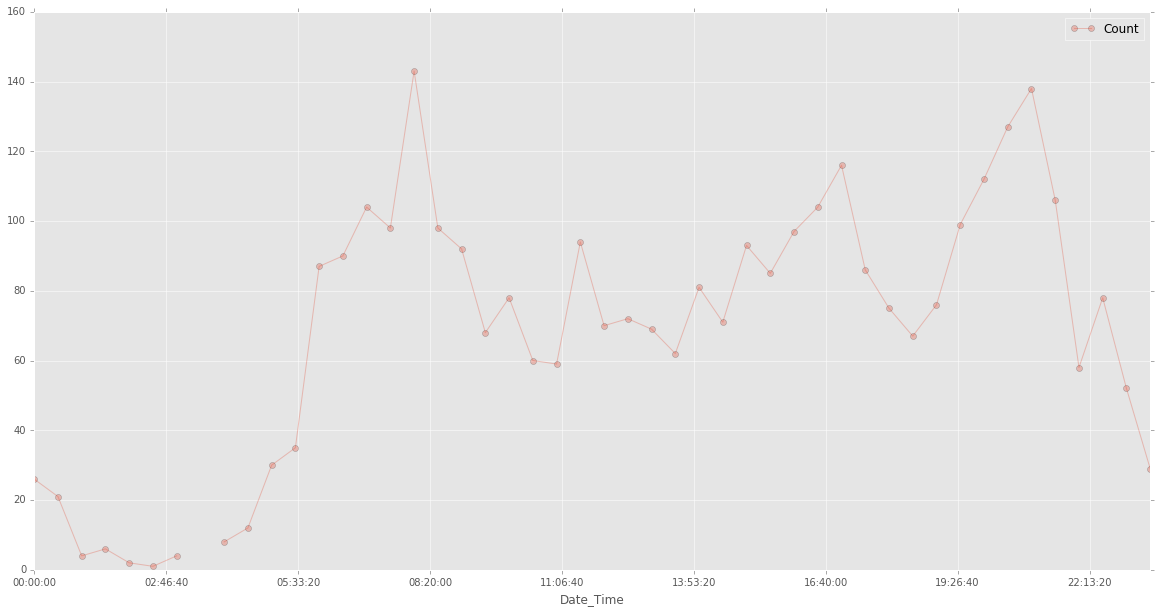

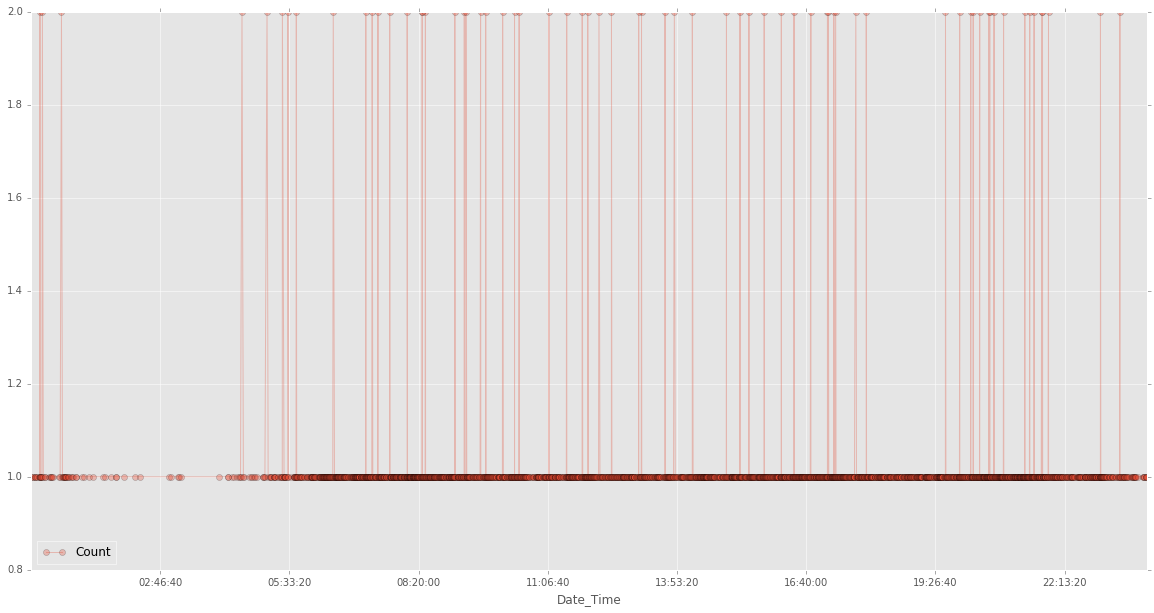

In [27]:
eastern = timezone('US/Eastern')
zurich = timezone('Europe/Zurich')

# Quick day light saving hack
dls = timedelta(seconds=3600)

fmt = '%Y-%m-%d %H:%M:%S %Z%z'
simple_time_format = '%H:%M'
# Used to put all timestamps in one day
one_day_time_format = '2017-01-01 %H:%M:%S'


print("Got {0} tweets".format(len(outtweets)))

dt_series = []

for tweets in outtweets:
    timestamp = tweets[1]
    # print(timestamp)
    loc_dt = zurich.localize(timestamp) + dls
#     print("Localized Zurich Timezone: {0}".format(loc_dt.strftime(fmt)))    
    eastern_dt = loc_dt.astimezone(eastern)
#     print("Localized Eastern Timezone: {0}".format(eastern_dt.strftime(one_day_time_format)))
    
    one_day_dt =datetime.datetime.strptime(eastern_dt.strftime(one_day_time_format), '%Y-%m-%d %H:%M:%S')
    
    dt_series.append(one_day_dt)
    

series = pd.Series(1, index=dt_series)
binned = series.resample('30T').sum()

counted = Counter(dt_series)
values = []

for key, value in dict(counted).items():
    values.append(value)

df2 = pd.DataFrame({ 'Date_Time' : list(counted),
                     'Count' : values})

binned_df = pd.DataFrame({'Date_Time':binned.index, 'Count':binned.values})

# print(binned.index)
# print(binned.values)

# print(binned_df.Date_Time.dt.time)
binned_df.plot.line(x=binned_df.Date_Time.dt.time, y='Count', marker='o', alpha=0.3, figsize=(20,10))

# print(df2.Date_Time.dt.hour)
df2.plot.line(x=df2.Date_Time.dt.time, y='Count', marker='o', alpha=0.3, figsize=(20,10))

# print(df2.Date_Time.dt.time)
# df2.plot.line(x=df2.Date_Time.dt.time)
# ppd = pd.Series(dt_series)
# print(ppd)
    

In [ ]:
list(counted)

In [ ]:
# series = pd.Series(1, index=dt_series)
binned = series.resample('30T').sum()

binned_df = pd.DataFrame({'Date_Time':binned.index, 'Count':binned.values})
print(binned_df)


In [100]:
def get_tweet_by_id(id):
    return [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8"), tweet._json] for tweet in alltweets if tweet.id_str == id]

                                    id   likes
833050081641234435  833050081641234435   69240
832950628750127106  832950628750127106   79521
832945737625387008  832945737625387008  147066
832742165436579840  832742165436579840   86872
832730328108134402  832730328108134402  105603
Most liked tweets got 634311 likes
Average likes 34321.68270120259


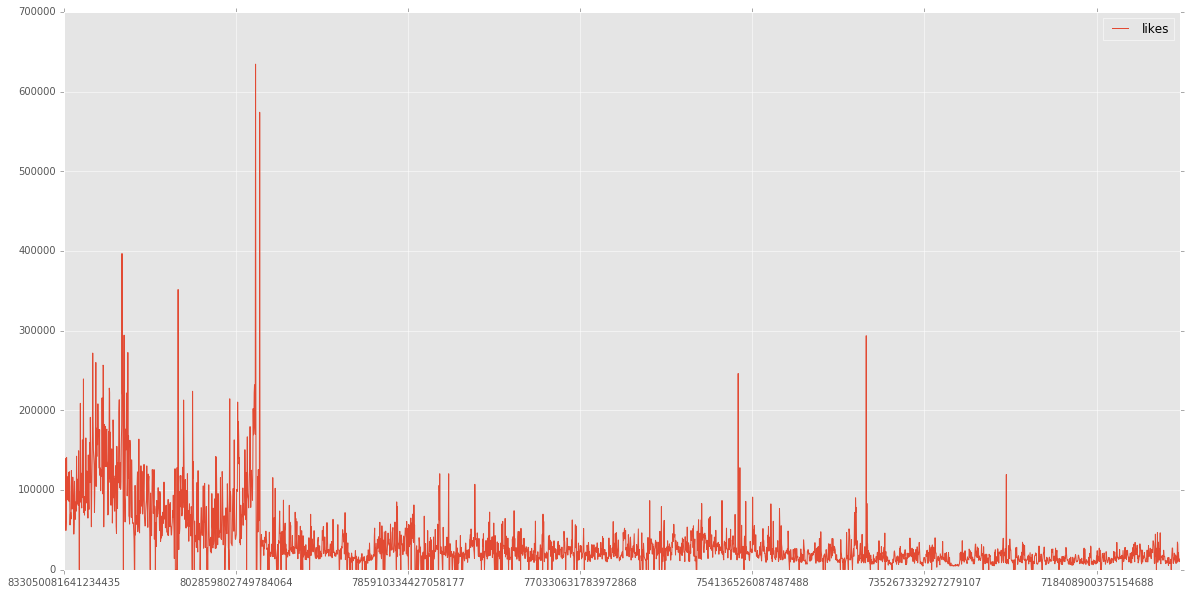

In [101]:
# favorite_count: Number of likes per tweet
favourite_tweets_list = [tweet.favorite_count for tweet in alltweets]
id_tweets_list = [tweet.id_str for tweet in alltweets]

# print(len(favourite_tweets_list))
# print(id_tweets_list)

df_fav = pd.DataFrame({'likes':favourite_tweets_list, 'id':id_tweets_list}, index=id_tweets_list)
print(df_fav.head())
max_df = df_fav['likes'].max()
print("Most liked tweets got {0} likes".format(max_df))

# df.loc[df['likes'].idxmax()]
max_likes_index = df_fav['likes'].idxmax()
# print(df_fav.loc[max_likes_index])

# most_liked_tweet = api.user_timeline(screen_name = screen_name, count = _count, max_id = oldest)

most_liked_tweet = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8"), tweet._json] for tweet in alltweets if tweet.id_str == max_likes_index]

print("Average likes {0}".format(df_fav['likes'].mean()))
df_fav.plot(figsize=(20,10))

    

In [102]:
print(most_liked_tweet[0][1])
print(most_liked_tweet[0][2])

2016-11-09 11:36:58
b'Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before'


In [103]:
 df_fav.sort_values(by='likes', ascending=False)

,id,likes
796315640307060738,796315640307060738,634311
795954831718498305,795954831718498305,573937
823174199036542980,823174199036542980,396734
815185071317676033,815185071317676033,351584
822669114237943808,822669114237943808,294355
741007091947556864,741007091947556864,293634
822421390125043713,822421390125043713,272571
828447350200926212,828447350200926212,271899
827885966509604865,827885966509604865,260054
826774668245946368,826774668245946368,256665


In [106]:
second_highest = get_tweet_by_id('795954831718498305')
print(second_highest[0][1])
print(second_highest[0][2])

2016-11-08 11:43:14
b'TODAY WE MAKE AMERICA GREAT AGAIN!'
